In [1]:
import torch, torchvision, PIL, numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import pandas as pd
from google.colab import drive
import shutil
import os

Get images and data. Relevant files are found in the respository except the images, which are found here: https://drive.google.com/file/d/1-0yYrZAs-BoonZeXHhS5Cb5jWHzlNFvK/view?usp=sharing.

In [2]:
drive.mount('/content/drive')
with open(f'/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/annotations_with_bbox.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/annotations_with_bbox.csv", "annotations_with_bbox.csv")

dataset = pd.read_csv('annotations_with_bbox.csv')

with open('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'images.tar.gz')

drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
!tar xfz images.tar.gz

In [4]:
dataset

,Unnamed: 0,id,x,y,w,h,label
0,0,015601864.jpg,653.204915,221.000000,7.795085,10.000000,1
1,1,015601864.jpg,584.734004,269.000000,62.531992,125.000000,1
2,2,015601864.jpg,638.038276,188.000000,22.961724,33.000000,2
3,3,015601864.jpg,549.408423,185.000000,66.591577,84.000000,2
4,4,015601864.jpg,573.000000,136.911589,119.000000,60.176823,3
...,...,...,...,...,...,...,...
127530,127530,025398745.jpg,879.486367,259.000000,63.513633,104.000000,2
127531,127531,025398745.jpg,868.288729,118.000000,102.711271,141.000000,3
127532,127532,025398745.jpg,871.000000,165.000000,46.000000,63.000000,4
127533,127533,025398745.jpg,894.986986,118.000000,24.026028,47.000000,5


In [12]:
drive.mount('/content/drive')
with open('/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/2nd_dataset.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/2nd_dataset.csv", "2nd_dataset.csv")

dataset2 = pd.read_csv('2nd_dataset.csv')

with open('/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/dataset2.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/dataset2.tar.gz', 'dataset2.tar.gz')

drive.flush_and_unmount()

Mounted at /content/drive


In [13]:
!tar xfz dataset2.tar.gz

In [14]:
!mv dataset images_2

In [15]:
print(len(os.listdir('images_2')))
print(len(dataset2))
print(len(dataset2["image"].unique()))

7490
7490
7490


In [17]:
dataset2.columns = ['Unnamed: 0', 'id', 'x', 'y', 'w', 'h', 'label']
dataset2

,Unnamed: 0,id,x,y,w,h,label
0,0,ball0040.jpg,200.34,113.73,45.13,45.59,7
1,1,ball0037.jpg,202.39,113.73,44.68,45.59,7
2,2,ball0254.jpg,203.30,113.73,44.68,45.13,7
3,3,ball0300.jpg,203.30,114.19,44.68,44.90,7
4,4,ball0021.jpg,201.94,114.19,45.35,45.58,7
...,...,...,...,...,...,...,...
7485,7570,dog-toy2292.jpg,225.00,145.00,34.00,56.00,16
7486,7571,dog-toy2293.jpg,223.00,151.00,34.00,56.00,16
7487,7572,dog-toy2294.jpg,221.00,157.00,34.00,57.00,16
7488,7573,dog-toy2295.jpg,219.00,164.00,34.00,57.00,16


Create the dataset class.

In [55]:
class DetectionDataset(torch.utils.data.Dataset):
  def __init__(self, df, image_dir, transform=None):
    super().__init__()

    self.df = df
    self.image_ids = self.df['id'].unique()
    self.image_dir = pathlib.Path(image_dir).resolve()
    self.transform = transform
  
  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    records = self.df[self.df['id'] == image_id]
    im = PIL.Image.open(self.image_dir/image_id).convert('RGB')
    im = torchvision.transforms.ToTensor()(im)

    # bounding box coordinates are stored with width and height while we want an endpoint
    boxes = records[['x', 'y', 'w', 'h']].values
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    labels = torch.tensor(records['label'].values)


    # if self.transform:
    #   im = self.transform(im)

    target = {
        'boxes': boxes,
        'labels': labels,
        'image_id': torch.tensor([idx]),
        'area': area
    }

    # if self.transform:
    #   im, target = self.transform(im, target)

    return im, target

  def __len__(self):
    return self.image_ids.shape[0]

In [6]:
dataset_full = DetectionDataset(dataset, 'images_data')

In [7]:
dataset_full[0]

(tensor([[[0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0431, 0.0510, 0.0510,  ..., 0.0275, 0.0314, 0.0392],
          ...,
          [0.5843, 0.5882, 0.5882,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0314, 0.0314, 0.0235,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0039, 0.0039],
          [0.0706, 0.0706, 0.0667,  ..., 0.0314, 0.0353, 0.0314],
          ...,
          [0.5804, 0.5843, 0.5843,  ..., 0.0196, 0.0196, 0.0196],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
          [0.0275, 0.0275, 0.0196,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0118, 0.0196,  ..., 0.0353, 0.0353, 0.0353],
          [0.0941, 0.0941, 0.1098,  ...,

In [8]:
print(dataset.loc[0])

Unnamed: 0                0
id            015601864.jpg
x                   653.205
y                       221
w                   7.79508
h                        10
label                     1
Name: 0, dtype: object


Now to check how it looks as a picture instead of just numbers.

In [9]:
classes = {
    1: 'shin',
    2: 'thigh',
    3: 'torso',
    4: 'forearm',
    5: 'uparm',
    6: 'head',
    7: 'ball',
    8: 'cup',
    9: 'juice',
    10: 'rubikscube',
    11: 'hand',
    12: 'bird',
    13: 'motorcycle',
    14: 'bike',
    15: 'car',
    16: 'toy-dog'
}

In [10]:
def show_img(img, title=None):
  if torch.is_tensor(img):
    img = img.cpu().permute(1,2,0)
  plt.imshow(img)
  if title:
    plt.title(title, color='w')
  plt.axis('off')

def show_boxes(img, sample, classes=None):
  show_img(img)
  ax = plt.gca()
  boxes = sample['boxes']
  labels = sample['labels']
  xmin, xmax = ax.get_xlim()
  ymax, ymin = ax.get_ylim()
  isx, isy = xmax-xmin, ymax-ymin
  for i in range(boxes.shape[0]):
    box = boxes[i]
    label = labels[i]
    # x = max(xmin, box[0])
    # y = max(ymin, box[1])
    # w = min(box[2] - x, xmax - x)
    # h = min(box[3] - y, ymax - y)
    # x = xmin + isx * box[0]
    # y = ymin + isy * box[1]
    # w = isx * (box[2] - box[0])
    # h = isy * (box[3] - box[1])
    x = box[0]
    y = box[1]
    w = box[2] - x
    h = box[3] - y
    bbox = patches.Rectangle((x, y), w, h, ec='r', fc='none')
    ax.add_patch(bbox)
    if classes:
      plt.text(x, y, classes[label.item()], backgroundcolor='r', c='w')


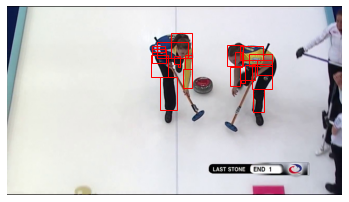

In [11]:
im, result = dataset_full[0]

show_boxes(im, result) #plotting with labels makes it impossible to see


That looks good, now to combine the datasets.

In [18]:
dataset_comb = dataset.append(dataset2, ignore_index=True)


In [19]:
dataset_comb

,Unnamed: 0,id,x,y,w,h,label
0,0,015601864.jpg,653.204915,221.000000,7.795085,10.000000,1
1,1,015601864.jpg,584.734004,269.000000,62.531992,125.000000,1
2,2,015601864.jpg,638.038276,188.000000,22.961724,33.000000,2
3,3,015601864.jpg,549.408423,185.000000,66.591577,84.000000,2
4,4,015601864.jpg,573.000000,136.911589,119.000000,60.176823,3
...,...,...,...,...,...,...,...
135020,7570,dog-toy2292.jpg,225.000000,145.000000,34.000000,56.000000,16
135021,7571,dog-toy2293.jpg,223.000000,151.000000,34.000000,56.000000,16
135022,7572,dog-toy2294.jpg,221.000000,157.000000,34.000000,57.000000,16
135023,7573,dog-toy2295.jpg,219.000000,164.000000,34.000000,57.000000,16


In [20]:
dataset_comb.drop(labels="Unnamed: 0", axis='columns')

,id,x,y,w,h,label
0,015601864.jpg,653.204915,221.000000,7.795085,10.000000,1
1,015601864.jpg,584.734004,269.000000,62.531992,125.000000,1
2,015601864.jpg,638.038276,188.000000,22.961724,33.000000,2
3,015601864.jpg,549.408423,185.000000,66.591577,84.000000,2
4,015601864.jpg,573.000000,136.911589,119.000000,60.176823,3
...,...,...,...,...,...,...
135020,dog-toy2292.jpg,225.000000,145.000000,34.000000,56.000000,16
135021,dog-toy2293.jpg,223.000000,151.000000,34.000000,56.000000,16
135022,dog-toy2294.jpg,221.000000,157.000000,34.000000,57.000000,16
135023,dog-toy2295.jpg,219.000000,164.000000,34.000000,57.000000,16


Combine the image folders.

In [21]:
!mkdir images_full

In [22]:
for fn in os.listdir('images_data'):
  shutil.copy(f'images_data/{fn}', f'images_full/{fn}')
for fn in os.listdir('images_2'):
  shutil.copy(f'images_2/{fn}', f'images_full/{fn}')

In [27]:
print(len(os.listdir('images_full')))
print(len(dataset_comb['id'].unique()))

16542
16542


In [57]:
dataset_full = DetectionDataset(dataset_comb, 'images_full')

Now to make the actual model.

In [29]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_FRCNN_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [30]:
model = get_FRCNN_model(len(classes)+1) #+1 because of background being class 0

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
device = torch.device('cuda:0')
model.to(device)

In [59]:
n_all = len(dataset_full)
n_used = int(1 * n_all)
n_train = int(0.8 * n_used)
n_test = n_used - n_train
rng = torch.Generator().manual_seed(291)


In [60]:
#Note, dataset 1 is much larger than 2 so the split is likely very imbalanced. Look into later.
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)

In [61]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [62]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Get some Pytorch reference code to make things easier.

In [36]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2314, done.
remote: Counting objects: 100% (2314/2314), done.
remote: Compressing objects: 100% (507/507), done.
remote: Total 20926 (delta 1801), reused 2213 (delta 1749), pack-reused 18612
Receiving objects: 100% (20926/20926), 21.71 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (15352/15352), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [51]:
from engine import train_one_epoch, evaluate

Finally, training.

In [63]:
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, loader_train, device, epoch, print_freq=10)
  scheduler.step()
  evaluate(model, loader_train, device=device)

RuntimeError: ignored